# Blinky for Versa ECP5G board

So far we've been 'virtual' and did not really create a design for download to an FPGA board yet.
We're going to tackle that now.

However, there's a few obstacles: Since we are going into real hardware, there are some technology/architecture specific
entities we might need to address. These are provided by the vendor as a components library in Verilog or VHDL, but obviously not MyHDL. So they are wrapped as a blackbox stub which is imported from the `synthesis.yosys.<platform>.components` library.

## Clock sourcing: The OSCG blackbox

Then we create a clock source using the blackbox OSCG module. This is an on-chip oscillator that
can be parametrized with a simple divider. For details, please consult the Lattice Technical Note [TN1263](http://www.latticesemi.com/view_document?document_id=50465).
To spice it up a little, we also use a dedicated clock divider element `CLKDIVF`.

## Top level entity

Then we create the top level module. It's input/output ports are the true hardware ports as described in the preference file (LPF).

In [1]:
import config

from myhdl import *
from synthesis.yosys.ecp5.components import OSCG, CLKDIVF

@block
def toplevel(clk_in, reset_n, uart_rxd, uart_txd, led, CLK_FREQ):
    "Top level entity with UART hard loopback"
    
    toggle_led0, toggle_led1 = [ Signal(bool()) for i in range(2) ]
    counter0, counter1 = [ Signal(intbv(0)[32:]) for i in range(2) ]

    oclk, dclk = [ Signal(bool()) for i in range(2) ]
    
    l = [ Signal(bool()) for i in range(8) ]
    l_out = Signal(intbv()[8:])

    # Use the oscillator clock, a Divider of 31 is approx 10 MHz
    osc_inst = OSCG(oclk, DIV=31)
    clkdiv_inst = CLKDIVF(oclk, 0, 0, dclk, DIV="2.0")
    
    @always_seq(oclk.posedge, reset_n)
    def worker0():
        counter0.next = counter0 + 1
        if counter0 == CLK_FREQ:
            toggle_led0.next = not toggle_led0
            counter0.next = 0

    @always_seq(dclk.posedge, reset_n)
    def worker1():
        counter1.next = counter1 + 1
        if counter1 == CLK_FREQ:
            toggle_led1.next = not toggle_led1
            counter1.next = 0            
            
    @always_comb
    def assign():
        l_out.next = concat(False, toggle_led1, False, False, True, False, toggle_led0, False)
        
    @always_comb
    def assign_out():
        led.next = not l_out
        uart_txd.next =  uart_rxd
            
    return instances()

### Synthesis

In [2]:
from myhdl.conversion import yshelper

clk_in = Signal(bool())
uart_rxd, uart_txd = [ Signal(bool()) for i in range(2) ]
led = Signal(modbv()[8:])
reset_n = ResetSignal(1, 0, False)

blinky = toplevel(clk_in, reset_n, uart_rxd, uart_txd, led, 10000000)

design = yshelper.Design("blinky")
blinky.convert("yosys_module", design)

design.finalize("top")


CREATE Module: 'OSCG_0'
	Infer blackbox: 'OSCG_0'
Adding module with name: OSCG_1
config param DIV = 31
Adding module with name: OSCG
KEYWORD VAR **parameter
CREATE Module: 'CLKDIVF_0'
	Infer blackbox: 'CLKDIVF_0'
Adding module with name: CLKDIVF_1_c0_c0_1
config param DIV = 2.0
Adding module with name: CLKDIVF
KEYWORD VAR **parameter
CREATE Module: 'toplevel'
Adding module with name: toplevel_1_1_1_1_8_c10000000
SIGNAL ARRAY 'l'
CONVERT_RTL tree >>>>>> 'TOPLEVEL_WORKER0' 
TRUNC: <ipython-input-1-ec0afd98d939>:24 Implicit carry truncate: counter0[32:], src[33:]
CONVERT_RTL tree >>>>>> 'TOPLEVEL_WORKER1' 
TRUNC: <ipython-input-1-ec0afd98d939>:31 Implicit carry truncate: counter1[32:], src[33:]
CONVERT_RTL tree >>>>>> 'TOPLEVEL_ASSIGN' 
CONVERT_RTL tree >>>>>> 'TOPLEVEL_ASSIGN_OUT' 
++++++++ OSCG_0: OSCG_1 (Module) ++++++++
++++++++ CLKDIVF_0: CLKDIVF_1_c0_c0_1 (Module) ++++++++
DONE instancing submodules


### RTL display (toplevel)

Generating RTL image...
Display...


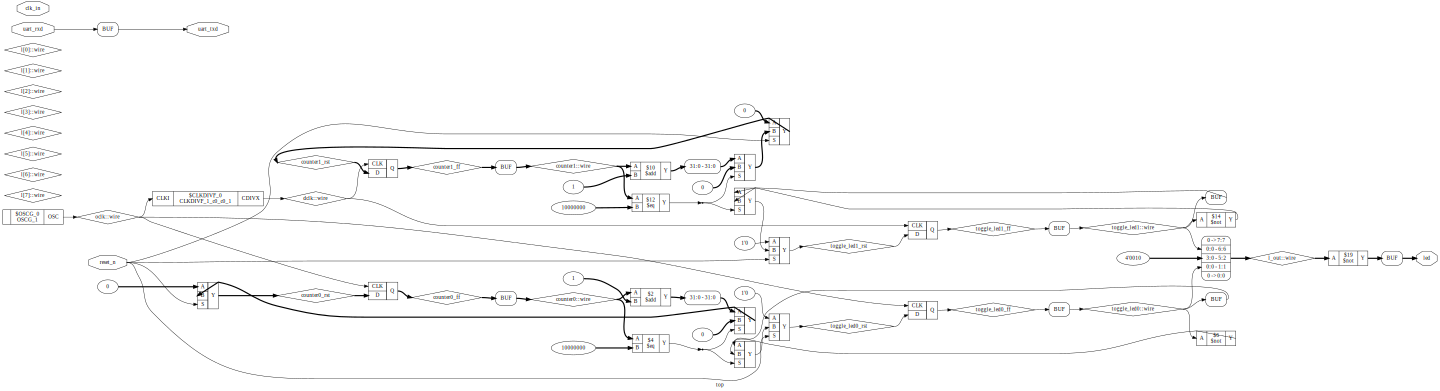

In [3]:
from ys_aux import *
display(to_svg(design, "top", 200 ))

## Technology mapping to ECP5

You might have to install the yosys and technology lib packages:

In [4]:
! sudo apt-get update
! sudo apt-get -y install yosys-ghdl yosys-techlibs

Get:2 http://security.debian.org/debian-security buster/updates InRelease [65.4 kB]
Hit:3 http://deb.debian.org/debian buster InRelease                            
Get:4 http://deb.debian.org/debian buster-updates InRelease [51.9 kB]
Hit:1 https://section5.ch/debian buster InRelease               
Get:5 http://security.debian.org/debian-security buster/updates/main amd64 Packages [213 kB]
Fetched 330 kB in 1s (234 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  yosys-ghdl yosys-techlibs
0 upgraded, 2 newly installed, 0 to remove and 0 not upgraded.
Need to get 9729 kB of archives.
After this operation, 37.6 MB of additional disk space will be used.
Get:1 https://section5.ch/debian buster/non-free amd64 yosys-ghdl amd64 0.9-testing-hpg [9483 kB]
Get:2 https://section5.ch/debian buster/non-free amd64 yosys-techlibs amd64 0.9-testing-hpg [246 kB]
Fetched 9729

Then synthesize and map:

In [5]:
TECHLIBS_PATH = "/usr/share/yosys"
YOSYS_ABC_EXE = "/usr/bin/yosys-abc"

commands = [ "read_verilog -lib -specify %s/ecp5/cells_sim.v %s/ecp5/cells_bb.v" % (TECHLIBS_PATH, TECHLIBS_PATH) ]
commands += ["hierarchy -check"]

commands += [ "proc", "flatten", "tribuf -logic", "deminout", "opt_expr", "debug opt_clean"]
# commands += [ "stat"]
commands += [ "check", "opt", "wreduce", "peepopt", "opt_clean", "share"]
commands += [ "techmap -map %s/cmp2lut.v -D LUT_WIDTH=4" % TECHLIBS_PATH ]
commands += [ "opt_expr", "opt_clean" ]
commands += [ "opt", "fsm", "opt -fast", "memory -nomap", "opt_clean"]
# commands += [ "memory_bram -rules %s/ecp5/lutrams.txt"  % TECHLIBS_PATH, "techmap -map %s/ecp5/lutrams_map.v" % TECHLIBS_PATH ]
commands += [ "techmap -map %s/techmap.v -map %s/ecp5/arith_map.v" % (TECHLIBS_PATH, TECHLIBS_PATH) ]

commands += [ "dff2dffs; opt_clean" ]
commands += [ "dff2dffe -direct-match $_DFF_* -direct-match $_SDFF_*" ]
commands += [ "techmap -map %s/ecp5/cells_map.v" % TECHLIBS_PATH ]
commands += [ "opt_expr -undriven -mux_undef" ]
commands += [ "simplemap; ecp5_ffinit" ]
commands += [ "ecp5_gsr", "attrmvcp -copy -attr syn_useioff" ]
commands += [ "abc -exe %s" % YOSYS_ABC_EXE ]
commands += [ "techmap -map %s/ecp5/latches_map.v" % TECHLIBS_PATH ]
commands += [ "abc -exe %s -lut 4:7 -dress" % YOSYS_ABC_EXE ]
commands += [ "clean" ]
commands += [ "techmap -map %s/ecp5/cells_map.v" % TECHLIBS_PATH ]
commands += [ "opt_lut_ins -tech ecp5", "clean" ]
commands += [ "autoname", "hierarchy -check", "stat", "check -noinit" ]

design.run(commands, silent=False)


Note: Capturing currently broken


## Place'n'Route

You might have to install the nextpnr and the libtrellis package first:

In [6]:
! sudo apt-get -y install nextpnr-ecp5 libtrellis >/dev/null

debconf: delaying package configuration, since apt-utils is not installed


Then write out the JSON file for the PnR step:

In [7]:
json_filename = "design.json"

design.run("write_json %s" % json_filename)
# Output of RTLIL for debugging purposes:
# design.run("write_ilang design.il")

### Running nextpnr


In [13]:
! nextpnr-ecp5 --json design.json --um5g-45k\
    --lpf boards/ecp5_versa.lpf --freq 100 --lpf-allow-unconstrained\
    --textcfg design.config --package=CABGA381 2>/dev/null

## Generate a programming file

In [9]:
! ecppack --svf design.svf design.config design.svf

## Programming your target

Programming the target only works when the host running this webserver has a Versa ECP5 board connected and if the permissions are set accordingly.
If not, you'll have to download the generated [SVF file](design.svf) and program your target locally.

In [10]:
# Install OPENOCD
! sudo apt-get install -y openocd

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libftdi1-2 libhidapi-hidraw0 libjaylink0 libjim0.77 libusb-0.1-4
  libusb-1.0-0
The following NEW packages will be installed:
  libftdi1-2 libhidapi-hidraw0 libjaylink0 libjim0.77 libusb-0.1-4
  libusb-1.0-0 openocd
0 upgraded, 7 newly installed, 0 to remove and 0 not upgraded.
Need to get 2710 kB of archives.
After this operation, 6939 kB of additional disk space will be used.
Get:1 http://deb.debian.org/debian buster/main amd64 libusb-1.0-0 amd64 2:1.0.22-2 [55.3 kB]
Get:2 http://deb.debian.org/debian buster/main amd64 libftdi1-2 amd64 1.4-1+b2 [30.2 kB]
Get:3 http://deb.debian.org/debian buster/main amd64 libhidapi-hidraw0 amd64 0.8.0~rc1+git20140818.d17db57+dfsg-2 [10.4 kB]
Get:4 http://deb.debian.org/debian buster/main amd64 libjaylink0 amd64 0.1.0-1 [17.1 kB]
Get:5 http://deb.debian.org/debian buster/main amd64 libusb-0.1-4 amd64 2

And finally download to target. The `INITN` LED should be off during successful programming. After approx. one second, one of the orange LEDs should start blinking on the board, while a green LED is permanently on.

We run openocd with prepended `sudo` to ensure access to the device. Note that the board must have been plugged in before starting the container.

In [11]:
! sudo openocd -f boards/ecp5_versa.cfg -f boards/LFE5UM5G-45F.cfg \
    -c "transport select jtag; init; svf design.svf quiet; exit"

Open On-Chip Debugger 0.10.0
Licensed under GNU GPL v2
For bug reports, read
	http://openocd.org/doc/doxygen/bugs.html
none separate
adapter speed: 5000 kHz
Info : auto-selecting first available session transport "jtag". To override use 'transport select <transport>'.
Warn : Transport "jtag" was already selected
Info : clock speed 5000 kHz
Info : JTAG tap: ecp5.tap tap/device found: 0x81112043 (mfg: 0x021 (Lattice Semi.), part: 0x1112, ver: 0x8)
Warn : gdb services need one or more targets defined
svf processing file: "design.svf"

Time used: 0m2s143ms 
svf file programmed successfully for 1068 commands with 0 errors
